**<center>Appendix A</center>**
<center>Computer Code</center>

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse.linalg import norm
import random
import matplotlib.pyplot as plt
import time

In [2]:
# compute mean squared error: NORM(UV-M, 'fro')
def MSE(U, V, M, obs):
    s = 0
    st = 0
    nSamp = len(obs)
    for l in range(nSamp):
        i, j = obs[l]
        s += (np.dot(U[i, :], V[j, :].T) - M[i, j])**2
    return np.sqrt(s)

# compute relative Frobenius error: NORM(UV-M, 'fro')/NORM(M, 'fro')
def RelError(U, V, M, obs):
    s = 0
    st = 0
    nSamp = len(obs)
    for l in range(nSamp):
        i, j = obs[l]
        s += (np.dot(U[i, :], V[j, :].T) - M[i, j])**2
        st += (M[i, j])**2
    return np.sqrt(s)/np.sqrt(st)

In [3]:
### TEST 1: MOVIELENS ###

# read in the movielens dataset https://www.kaggle.com/grouplens/movielens-latest-small
dataset = pd.read_csv('ratings.csv').drop('timestamp', axis=1)
print(dataset.shape)

# convert to numpy matrix
M = dataset.pivot(index='userId', columns='movieId', values='rating').values
print(M.shape)
M

(100836, 3)
(610, 9724)


array([[4. , nan, 4. , ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [2.5, 2. , 2. , ..., nan, nan, nan],
       [3. , nan, nan, ..., nan, nan, nan],
       [5. , nan, nan, ..., nan, nan, nan]])

In [4]:
# produce vectors of users, movies, ratings (given values)
users = dataset['userId'].values
movies = dataset['movieId'].values
ratings = dataset['rating'].values
obs = [(users[i]-1, movies[i]-1) for i in range(len(users))] # form tuples

# form sparse matrix
M = sparse.coo_matrix((ratings, (users-1,movies-1))).tocsr()
print(M)

  (0, 0)	4.0
  (0, 2)	4.0
  (0, 5)	4.0
  (0, 46)	5.0
  (0, 49)	5.0
  (0, 69)	3.0
  (0, 100)	5.0
  (0, 109)	4.0
  (0, 150)	5.0
  (0, 156)	5.0
  (0, 162)	5.0
  (0, 215)	5.0
  (0, 222)	3.0
  (0, 230)	5.0
  (0, 234)	4.0
  (0, 259)	5.0
  (0, 295)	3.0
  (0, 315)	3.0
  (0, 332)	5.0
  (0, 348)	4.0
  (0, 355)	4.0
  (0, 361)	5.0
  (0, 366)	4.0
  (0, 422)	3.0
  (0, 440)	4.0
  :	:
  (609, 156370)	5.0
  (609, 156725)	4.5
  (609, 157295)	4.0
  (609, 158237)	5.0
  (609, 158720)	3.5
  (609, 158871)	3.5
  (609, 158955)	3.0
  (609, 159092)	3.0
  (609, 160079)	3.0
  (609, 160340)	2.5
  (609, 160526)	4.5
  (609, 160570)	3.0
  (609, 160835)	3.0
  (609, 161581)	4.0
  (609, 161633)	4.0
  (609, 162349)	3.5
  (609, 163936)	3.5
  (609, 163980)	3.5
  (609, 164178)	5.0
  (609, 166527)	4.0
  (609, 166533)	4.0
  (609, 168247)	5.0
  (609, 168249)	5.0
  (609, 168251)	5.0
  (609, 170874)	3.0


In [5]:
# set up parameters for SGD
maxiter = 50

alpha = 0.1 # step size (learning rate)
beta = 0.01 # regularization

nSamp = len(obs) # size of the observed set

np.random.shuffle(obs)

# form training and test sets (hyperparameter)
train = obs[1:(int)(np.floor(0.7*nSamp))] # training set [70%]
test = obs[(int)(np.floor(0.7*nSamp)):len(obs)+1] # test set [30%]

start = time.time()

# start SGD

k = 10 # guess of the rank of matrix

# initialize matrices
U = np.random.normal(size=(np.max(users), k), scale=1/k)
V = np.random.normal(size=(np.max(movies), k), scale=1/k)

errorVec = np.zeros((2, maxiter), dtype='float')

RelErr_prev = 1
for itr in range(maxiter):
    np.random.shuffle(train)
    selected_updates = train[1:(int)(np.floor(0.1*len(train)))] # batch size (hyperparameter) [10%]
    
    for l in selected_updates:
        i, j = l
        error = ( np.dot(U[i, :], V[j, :].T) - M[i, j] )
        U_temp = np.copy(U[i, :])
        # update U
        U[i, :] -= alpha * (error*V[j, :] + beta*U[i, :])
        # update V
        V[j, :] -= alpha * (error*U_temp + beta*V[j, :])

    errorVec[0, itr] = MSE(U, V, M, test)
    errorVec[1, itr] = RelError(U, V, M, test)

    # print errors during iteration
    if RelErr_prev - errorVec[1, itr] < 0.001:
        break
    else:
        print("iter", itr+1,
              ": MSE =", errorVec[0, itr],
              ", RelErr =", errorVec[1, itr])
        RelErr_prev = errorVec[1, itr]

end = time.time()
print("\nRunning time:", end-start)

iter 1 : MSE = 611.1950647241977 , RelErr = 0.9613515290180383
iter 2 : MSE = 403.547888914588 , RelErr = 0.6347423309366939
iter 3 : MSE = 325.84540103033703 , RelErr = 0.5125237302846443
iter 4 : MSE = 293.36336760592764 , RelErr = 0.461432590482555
iter 5 : MSE = 275.4578085038903 , RelErr = 0.4332688541990592
iter 6 : MSE = 263.6702196109559 , RelErr = 0.414728101402287
iter 7 : MSE = 255.86212088406293 , RelErr = 0.40244670699474283
iter 8 : MSE = 251.70578997879747 , RelErr = 0.39590919499325944
iter 9 : MSE = 247.23193494378745 , RelErr = 0.38887224782737756
iter 10 : MSE = 241.71540571643246 , RelErr = 0.3801952736276864

Running time: 49.79625988006592


In [6]:
# print matrices
print("True Answer")
print(M)
print("\nEstimated Answer")
print(np.dot(U, V.T))
print("\nAccuracy (estimated - true)")
print(np.dot(U, V.T)-M)

True Answer
  (0, 0)	4.0
  (0, 2)	4.0
  (0, 5)	4.0
  (0, 46)	5.0
  (0, 49)	5.0
  (0, 69)	3.0
  (0, 100)	5.0
  (0, 109)	4.0
  (0, 150)	5.0
  (0, 156)	5.0
  (0, 162)	5.0
  (0, 215)	5.0
  (0, 222)	3.0
  (0, 230)	5.0
  (0, 234)	4.0
  (0, 259)	5.0
  (0, 295)	3.0
  (0, 315)	3.0
  (0, 332)	5.0
  (0, 348)	4.0
  (0, 355)	4.0
  (0, 361)	5.0
  (0, 366)	4.0
  (0, 422)	3.0
  (0, 440)	4.0
  :	:
  (609, 156370)	5.0
  (609, 156725)	4.5
  (609, 157295)	4.0
  (609, 158237)	5.0
  (609, 158720)	3.5
  (609, 158871)	3.5
  (609, 158955)	3.0
  (609, 159092)	3.0
  (609, 160079)	3.0
  (609, 160340)	2.5
  (609, 160526)	4.5
  (609, 160570)	3.0
  (609, 160835)	3.0
  (609, 161581)	4.0
  (609, 161633)	4.0
  (609, 162349)	3.5
  (609, 163936)	3.5
  (609, 163980)	3.5
  (609, 164178)	5.0
  (609, 166527)	4.0
  (609, 166533)	4.0
  (609, 168247)	5.0
  (609, 168249)	5.0
  (609, 168251)	5.0
  (609, 170874)	3.0

Estimated Answer
[[ 4.27020683  4.90147728  5.21642394 ...  0.06357361 -0.34890203
   0.62410587]
 [ 2.95664264  3.

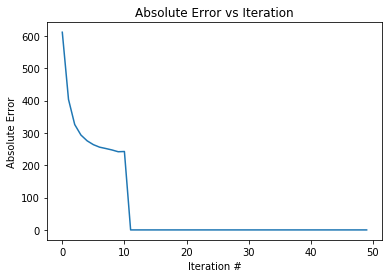

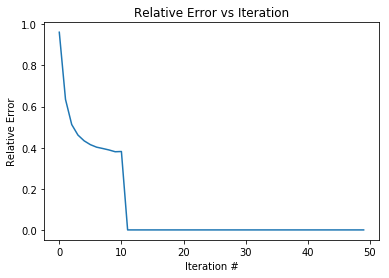

In [7]:
# plot error curves for maxiter
plt.plot(errorVec[0, :])
plt.title('Absolute Error vs Iteration')
plt.xlabel('Iteration #')
plt.ylabel('Absolute Error')
plt.show()

plt.plot(errorVec[1, :])
plt.title('Relative Error vs Iteration')
plt.xlabel('Iteration #')
plt.ylabel('Relative Error')
plt.show()

In [8]:
### TEST 2: MATRIX FROM WELL-SEPARATED KERNEL ###

# construct a low-rank matrix
N = 1000  # matrix size

d = 1 # dimension of point set
# generate well-separated point set
X = np.random.randn(d, N) + 5 # [the larger the distance, the smaller the rank]
Y = np.random.randn(d, N)  

bandwidth = 10 # bandwidth of Gaussian kernel [the larger the bandwidth, the smaller the rank]
M = np.zeros([N, N]) # fill in full true matrix M
for i in range(N):
    for j in range(N):
        M[i, j] = np.exp(-np.linalg.norm(X[:, i]-Y[:, j])**2/bandwidth)

print(M)
print("\nRank of M:", np.linalg.matrix_rank(M))

[[0.00513907 0.22012294 0.01979851 ... 0.15135983 0.01846026 0.02577823]
 [0.03506236 0.55706278 0.10071643 ... 0.43790368 0.09545886 0.12311703]
 [0.00885863 0.29268294 0.03160395 ... 0.20842955 0.02959429 0.04047517]
 ...
 [0.00442005 0.20294327 0.01738219 ... 0.13824478 0.01618869 0.02273235]
 [0.00514363 0.22022759 0.01981367 ... 0.1514402  0.01847451 0.02579729]
 [0.01771638 0.41117296 0.05693121 ... 0.30710481 0.05362276 0.07129178]]

Rank of M: 12


In [9]:
col_idx = [np.random.randint(1, N) for i in range(100000)]
row_idx = [np.random.randint(1, N) for i in range(100000)]
obs = [(i, j) for i, j in zip(row_idx, col_idx)]

# set up parameters for SGD
maxiter = 100

alpha = 0.1 # step size (learning rate)
beta = 0.01 # regularization

nSamp = len(obs) # size of the observed set

np.random.shuffle(obs)

# form training and test sets (hyperparameter)
train = obs[1:(int)(np.floor(0.7*nSamp))] # training set [70%]
test = obs[(int)(np.floor(0.7*nSamp)):len(obs)+1] # test set [30%]

# start SGD

k = 10 # guess of the rank of matrix

# initialize matrices
U = np.random.normal(size=(N, k), scale=1/k)
V = np.random.normal(size=(N, k), scale=1/k)

errorVec = np.zeros((2, maxiter), dtype='float')

for itr in range(maxiter):
    np.random.shuffle(train)
    selected_updates = train[1:(int)(np.floor(0.1*len(train)))] # batch size (hyperparameter) [10%]
    
    for l in selected_updates:
        i, j = l
        error = ( np.dot(U[i, :], V[j, :].T) - M[i, j] )
        U_temp = np.copy(U[i, :])
        # update U
        U[i, :] -= alpha * (error*V[j, :] + beta*U[i, :])
        # update V
        V[j, :] -= alpha * (error*U_temp + beta*V[j, :])

    errorVec[0, itr] = MSE(U, V, M, test)
    errorVec[1, itr] = RelError(U, V, M, test)

    # print errors during iteration
    print("iter", itr+1,
          ": MSE =", errorVec[0, itr],
          ", RelErr =", errorVec[1, itr])

iter 1 : MSE = 37.85447802254936 , RelErr = 1.0104046754648228
iter 2 : MSE = 37.82370083405363 , RelErr = 1.0095831764829792
iter 3 : MSE = 37.80564359178891 , RelErr = 1.0091011959363339
iter 4 : MSE = 37.78661736804037 , RelErr = 1.0085933515164343
iter 5 : MSE = 37.76372378055331 , RelErr = 1.0079822801440776
iter 6 : MSE = 37.7449215286283 , RelErr = 1.007480413938368
iter 7 : MSE = 37.724542366203345 , RelErr = 1.0069364571313564
iter 8 : MSE = 37.703730954034576 , RelErr = 1.006380962794707
iter 9 : MSE = 37.676434936142094 , RelErr = 1.0056523825700976
iter 10 : MSE = 37.650927236902966 , RelErr = 1.0049715358138378
iter 11 : MSE = 37.61397312777905 , RelErr = 1.0039851636172854
iter 12 : MSE = 37.57112190415671 , RelErr = 1.002841386739115
iter 13 : MSE = 37.52332077485157 , RelErr = 1.0015654879005775
iter 14 : MSE = 37.445621372538014 , RelErr = 0.9994915499286507
iter 15 : MSE = 37.343153350603686 , RelErr = 0.9967564925759538
iter 16 : MSE = 37.22385034127217 , RelErr = 0.

In [10]:
# print matrices
print("True Answer")
print(M)
print("\nEstimated Answer")
print(np.dot(U, V.T))
print("\nAccuracy (estimated - true)")
print(np.dot(U, V.T)-M)

True Answer
[[0.00513907 0.22012294 0.01979851 ... 0.15135983 0.01846026 0.02577823]
 [0.03506236 0.55706278 0.10071643 ... 0.43790368 0.09545886 0.12311703]
 [0.00885863 0.29268294 0.03160395 ... 0.20842955 0.02959429 0.04047517]
 ...
 [0.00442005 0.20294327 0.01738219 ... 0.13824478 0.01618869 0.02273235]
 [0.00514363 0.22022759 0.01981367 ... 0.1514402  0.01847451 0.02579729]
 [0.01771638 0.41117296 0.05693121 ... 0.30710481 0.05362276 0.07129178]]

Estimated Answer
[[-0.01766299  0.01814391  0.00814028 ... -0.01593543  0.01316297
  -0.029026  ]
 [ 0.0390221   0.54133806  0.09593972 ...  0.41298131  0.10677811
   0.14979037]
 [ 0.03438604  0.25181451  0.04483363 ...  0.20857155  0.04083663
   0.08644096]
 ...
 [ 0.03228397  0.16958962  0.02848478 ...  0.13665726  0.03225806
   0.05243882]
 [ 0.05345308  0.2210505   0.04081142 ...  0.16693716  0.03953436
   0.06662432]
 [ 0.06941458  0.3732521   0.06065793 ...  0.28840572  0.06071899
   0.10916358]]

Accuracy (estimated - true)
[[-2.

In [11]:
### TEST 3: RANK-1 MATRIX ###

# construct a low-rank matrix
N = 1000  # matrix size

# random normalized vectors
vec1 = np.random.randn(1, N)
vec2 = np.random.rand(N)
vec1 = vec1/np.linalg.norm(vec1)
vec2 = vec2/np.linalg.norm(vec2)

M = np.outer(vec1, vec2)

print(M)
print("\nRank of M:", np.linalg.matrix_rank(M))

[[ 9.59351214e-04  4.78202927e-05  9.19048499e-04 ...  5.87133876e-04
   6.12429240e-05  5.16328613e-04]
 [-3.36505627e-04 -1.67736251e-05 -3.22368895e-04 ... -2.05945278e-04
  -2.14817975e-05 -1.81109359e-04]
 [ 1.26658385e-03  6.31347617e-05  1.21337417e-03 ...  7.75163748e-04
   8.08559964e-05  6.81683070e-04]
 ...
 [-5.35926663e-04 -2.67140642e-05 -5.13412177e-04 ... -3.27993225e-04
  -3.42124088e-05 -2.88438964e-04]
 [-2.11358572e-03 -1.05354834e-04 -2.02479316e-03 ... -1.29353854e-03
  -1.34926779e-04 -1.13754459e-03]
 [-1.61216092e-03 -8.03605667e-05 -1.54443342e-03 ... -9.86660857e-04
  -1.02916896e-04 -8.67674738e-04]]

Rank of M: 1


In [12]:
col_idx = [np.random.randint(1, N) for i in range(100000)]
row_idx = [np.random.randint(1, N) for i in range(100000)]
obs = [(i, j) for i, j in zip(row_idx, col_idx)]

# set up parameters for SGD
maxiter = 100

alpha = 0.1 # step size (learning rate)
beta = 0.01 # regularization

nSamp = len(obs) # size of the observed set

np.random.shuffle(obs)

# form training and test sets (hyperparameter)
train = obs[1:(int)(np.floor(0.7*nSamp))] # training set [70%]
test = obs[(int)(np.floor(0.7*nSamp)):len(obs)+1] # test set [30%]

# start SGD

k = 10 # guess of the rank of matrix

# initialize matrices
U = np.random.normal(size=(N, k), scale=1/k)
V = np.random.normal(size=(N, k), scale=1/k)

errorVec = np.zeros((2, maxiter), dtype='float')

for itr in range(maxiter):
    np.random.shuffle(train)
    selected_updates = train[1:(int)(np.floor(0.1*len(train)))] # batch size (hyperparameter) [10%]
    
    for l in selected_updates:
        i, j = l
        error = ( np.dot(U[i, :], V[j, :].T) - M[i, j] )
        U_temp = np.copy(U[i, :])
        # update U
        U[i, :] -= alpha * (error*V[j, :] + beta*U[i, :])
        # update V
        V[j, :] -= alpha * (error*U_temp + beta*V[j, :])

    errorVec[0, itr] = MSE(U, V, M, test)
    errorVec[1, itr] = RelError(U, V, M, test)

    # print errors during iteration
    print("iter", itr+1,
          ": MSE =", errorVec[0, itr],
          ", RelErr =", errorVec[1, itr])

iter 1 : MSE = 5.486272079874367 , RelErr = 31.605341847625883
iter 2 : MSE = 5.336379978491398 , RelErr = 30.74184272919058
iter 3 : MSE = 5.192359127803759 , RelErr = 29.912166739210704
iter 4 : MSE = 5.054472104435736 , RelErr = 29.117826530331065
iter 5 : MSE = 4.924124876305148 , RelErr = 28.366921609105933
iter 6 : MSE = 4.798815722530692 , RelErr = 27.645040050186036
iter 7 : MSE = 4.675590221599263 , RelErr = 26.935162008305923
iter 8 : MSE = 4.559137131060492 , RelErr = 26.26429849987878
iter 9 : MSE = 4.446165130065232 , RelErr = 25.613488868368982
iter 10 : MSE = 4.338606873757441 , RelErr = 24.993866762565556
iter 11 : MSE = 4.234653506645783 , RelErr = 24.3950117192971
iter 12 : MSE = 4.133401580782098 , RelErr = 23.81171915139997
iter 13 : MSE = 4.036123397864225 , RelErr = 23.251318540443457
iter 14 : MSE = 3.9414919217973767 , RelErr = 22.706165090688437
iter 15 : MSE = 3.850381542332053 , RelErr = 22.18129599069761
iter 16 : MSE = 3.763115368600016 , RelErr = 21.678572

In [13]:
# print matrices
print("True Answer")
print(M)
print("\nEstimated Answer")
print(np.dot(U, V.T))
print("\nAccuracy (estimated - true)")
print(np.dot(U, V.T)-M)

True Answer
[[ 9.59351214e-04  4.78202927e-05  9.19048499e-04 ...  5.87133876e-04
   6.12429240e-05  5.16328613e-04]
 [-3.36505627e-04 -1.67736251e-05 -3.22368895e-04 ... -2.05945278e-04
  -2.14817975e-05 -1.81109359e-04]
 [ 1.26658385e-03  6.31347617e-05  1.21337417e-03 ...  7.75163748e-04
   8.08559964e-05  6.81683070e-04]
 ...
 [-5.35926663e-04 -2.67140642e-05 -5.13412177e-04 ... -3.27993225e-04
  -3.42124088e-05 -2.88438964e-04]
 [-2.11358572e-03 -1.05354834e-04 -2.02479316e-03 ... -1.29353854e-03
  -1.34926779e-04 -1.13754459e-03]
 [-1.61216092e-03 -8.03605667e-05 -1.54443342e-03 ... -9.86660857e-04
  -1.02916896e-04 -8.67674738e-04]]

Estimated Answer
[[ 0.06175911 -0.0018164  -0.00283631 ...  0.01472882  0.00721257
   0.01367728]
 [ 0.01646642  0.00473873 -0.0003908  ...  0.00592001 -0.00020123
   0.00401437]
 [-0.0170306  -0.0003385  -0.00150738 ...  0.00319896 -0.00196007
  -0.00041008]
 ...
 [-0.00494431 -0.00736253 -0.00344018 ... -0.00269096 -0.00492024
   0.0005428 ]
 [-0.

In [14]:
### TEST 4: LOW-RANK MATRIX WITH HIGH CONDITION NUMBER ###

# construct a low-rank matrix
N = 1000  # matrix size

tempM = np.random.randn(N,N)

U,S,V = np.linalg.svd(tempM)

# manipulate S to ensure low-rank
S[0] = 100
S[19] = 0.01
for i in range(20,N):
    S[i] = 0

M = U*S*V.T

print(M)
print("\nRank of M:", np.linalg.matrix_rank(M))
print("Condition number of M:", np.linalg.cond(M))

[[ 0.17208238  0.01705938 -0.04426555 ... -0.         -0.
  -0.        ]
 [ 0.2588888   0.01771982 -0.01113161 ...  0.          0.
   0.        ]
 [-0.04090502  0.0235689  -0.0022449  ... -0.          0.
   0.        ]
 ...
 [ 0.10131762 -0.00092461 -0.00976139 ... -0.          0.
   0.        ]
 [ 0.0939843  -0.00060227  0.00052677 ...  0.          0.
   0.        ]
 [-0.0183171   0.00171524 -0.00604721 ... -0.          0.
   0.        ]]

Rank of M: 20
Condition number of M: inf


In [15]:
col_idx = [np.random.randint(1, N) for i in range(100000)]
row_idx = [np.random.randint(1, N) for i in range(100000)]
obs = [(i, j) for i, j in zip(row_idx, col_idx)]

# set up parameters for SGD
maxiter = 100

alpha = 0.1 # step size (learning rate)
beta = 0.01 # regularization

nSamp = len(obs) # size of the observed set

np.random.shuffle(obs)

# form training and test sets (hyperparameter)
train = obs[1:(int)(np.floor(0.7*nSamp))] # training set 70%
test = obs[(int)(np.floor(0.7*nSamp)):len(obs)+1] # test set 30%

# start SGD

k = 20 # guess of the rank of matrix

# initialize matrices
U = np.random.normal(size=(N, k), scale=1/k)
V = np.random.normal(size=(N, k), scale=1/k)

errorVec = np.zeros((2, maxiter), dtype='float')

for itr in range(maxiter):
    np.random.shuffle(train)
    selected_updates = train[1:(int)(np.floor(0.1*len(train)))] # batch size (hyperparameter)
    
    for l in selected_updates:
        i, j = l
        error = ( np.dot(U[i, :], V[j, :].T) - M[i, j] )
        U_temp = np.copy(U[i, :])
        # update U
        U[i, :] -= alpha * (error*V[j, :] + beta*U[i, :])
        # update V
        V[j, :] -= alpha * (error*U_temp + beta*V[j, :])

    errorVec[0, itr] = MSE(U, V, M, test)
    errorVec[1, itr] = RelError(U, V, M, test)

    # print errors during iteration
    print("iter", itr+1,
          ": MSE =", errorVec[0, itr],
          ", RelErr =", errorVec[1, itr])

iter 1 : MSE = 2.3565136449916206 , RelErr = 1.7020667060125096
iter 2 : MSE = 2.3300653522250556 , RelErr = 1.6829635878767342
iter 3 : MSE = 2.304057863686501 , RelErr = 1.6641788545727039
iter 4 : MSE = 2.2790870329398145 , RelErr = 1.6461428802316516
iter 5 : MSE = 2.254287970588023 , RelErr = 1.6282309710606513
iter 6 : MSE = 2.23050098485324 , RelErr = 1.6110500663196086
iter 7 : MSE = 2.207378607126165 , RelErr = 1.594349195787098
iter 8 : MSE = 2.1848273119372896 , RelErr = 1.5780608077270402
iter 9 : MSE = 2.162898346108352 , RelErr = 1.562221916781491
iter 10 : MSE = 2.141364870436578 , RelErr = 1.5466686811430923
iter 11 : MSE = 2.120214642702452 , RelErr = 1.531392258480593
iter 12 : MSE = 2.09980923121665 , RelErr = 1.516653802971844
iter 13 : MSE = 2.0801782111959692 , RelErr = 1.502474676255018
iter 14 : MSE = 2.061025181202508 , RelErr = 1.4886407929925916
iter 15 : MSE = 2.042593439911437 , RelErr = 1.4753278833677974
iter 16 : MSE = 2.02443777059175 , RelErr = 1.46221

In [16]:
# print matrices
print("True Answer")
print(M)
print("\nEstimated Answer")
print(np.dot(U, V.T))
print("\nAccuracy (estimated - true)")
print(np.dot(U, V.T)-M)

True Answer
[[ 0.17208238  0.01705938 -0.04426555 ... -0.         -0.
  -0.        ]
 [ 0.2588888   0.01771982 -0.01113161 ...  0.          0.
   0.        ]
 [-0.04090502  0.0235689  -0.0022449  ... -0.          0.
   0.        ]
 ...
 [ 0.10131762 -0.00092461 -0.00976139 ... -0.          0.
   0.        ]
 [ 0.0939843  -0.00060227  0.00052677 ...  0.          0.
   0.        ]
 [-0.0183171   0.00171524 -0.00604721 ... -0.          0.
   0.        ]]

Estimated Answer
[[ 1.20782728e-02 -4.39258110e-04  8.29318428e-04 ...  9.39115821e-04
   2.66742305e-03  3.71426322e-03]
 [-6.75267155e-03  2.11121411e-03  2.10848559e-03 ... -3.41161736e-03
  -8.65584423e-04 -3.21577916e-05]
 [ 8.30148478e-03  1.99275771e-03  2.82820394e-03 ...  9.70560357e-04
  -1.36583621e-03  6.27179544e-04]
 ...
 [-3.68469937e-03  1.53832456e-03  4.25293669e-04 ... -1.91883377e-03
  -3.06175342e-03  1.94102416e-03]
 [ 2.30204924e-03  4.93317719e-04 -2.38828710e-03 ...  1.11174927e-03
  -2.95399044e-03 -1.59106019e-